# Generative Model 기반 Data Augmentation 실험

## 목적
1. Few-shot 환경에서 최적의 생성모델 조건 탐색
2. 전통적 증강의 포화점 개선 및 생성형 증강의 추가효과 평가

In [1]:
import torch
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

import warnings
warnings.filterwarnings('ignore')

## 환경 설정 및 GPU 확인

In [2]:
# CUDA 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
    torch.backends.cudnn.benchmark = True
else:
    print("Warning: CUDA not available, using CPU (will be very slow)")

# 실험 파라미터 (필요시 조정)
EPOCHS = 100              # 분류기 학습 에포크
BATCH_SIZE = 128          # 분류기 배치 크기 (메모리 부족 시 64로 줄이기)
LR = 0.05                 # 학습률
LORA_STEPS = 2000         # LoRA 학습 스텝 (Case A)
LORA_STEPS_B = 3000       # LoRA 학습 스텝 (Case B)
LORA_BATCH_SIZE = 2       # LoRA 배치 크기 (메모리 부족 시 1로 줄이기)

print(f"\nExperiment parameters:")
print(f"  Classifier epochs: {EPOCHS}")
print(f"  Classifier batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LR}")
print(f"  LoRA steps (A/B): {LORA_STEPS}/{LORA_STEPS_B}")
print(f"  LoRA batch size: {LORA_BATCH_SIZE}")
print("\nNote: GPU 메모리 부족 시 batch size down")

Using device: cuda
GPU: NVIDIA GeForce RTX 5080
GPU Memory: 16.59 GB
CUDA Version: 12.9

Experiment parameters:
  Classifier epochs: 100
  Classifier batch size: 128
  Learning rate: 0.05
  LoRA steps (A/B): 2000/3000
  LoRA batch size: 2

Note: GPU 메모리 부족 시 batch size down


## 실험 1: 최적 생성모델 탐색

9개의 생성모델군을 비교:
- Non-finetuned (vanilla SD)
- LoRA rank {4, 8, 16, 32} × Case {A, B}

In [3]:
from experiment_optimalGen import run_experiment_1

print("Starting Experiment 1...")
results_exp1, best_model = run_experiment_1()
print(f"\nExperiment 1 completed. Best model: {best_model}")

2025-11-24 18:55:36.040339: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-24 18:55:36.208502: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-24 18:55:37.026122: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Starting Experiment 1...

######################################################################
# EXPERIMENT 1: Optimal Generative Model Search
######################################################################

Preparing Traditional Augmentations for LoRA Training (500/class)
Train: 1000 images (100 per class)
Test: 10000 images
Already exists: ./data/aug_traditional_500
Train: 1000 images (100 per class)
Test: 10000 images

Training LoRA Models

Skipping rank4_caseA (already exists)

Skipping rank4_caseB (already exists)

Skipping rank8_caseA (already exists)

Skipping rank8_caseB (already exists)

Skipping rank16_caseA (already exists)

Skipping rank16_caseB (already exists)

Skipping rank32_caseA (already exists)

Skipping rank32_caseB (already exists)

Generating Augmentations from All Models

Skipping rank4_caseA (already exists)

Skipping rank4_caseB (already exists)

Skipping rank8_caseA (already exists)

Skipping rank8_caseB (already exists)

Skipping rank16_caseA (alread

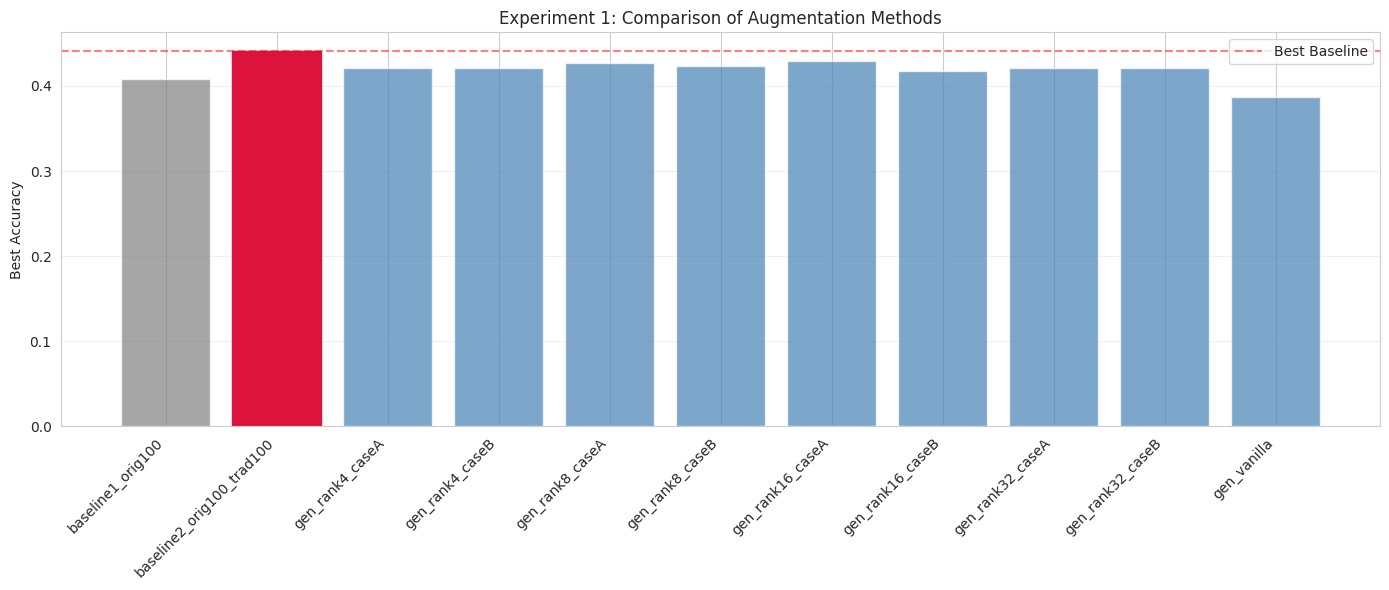


Best Model: baseline2_orig100_trad100
Best Accuracy: 0.4409


In [4]:
# 결과 로드
with open('./results/exp1_results.json', 'r') as f:
    results_exp1 = json.load(f)

# 데이터 정리
baselines = {k: v for k, v in results_exp1.items() if 'baseline' in k}
gen_models = {k: v for k, v in results_exp1.items() if 'gen_' in k}

# 막대 그래프
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

names = list(baselines.keys()) + list(gen_models.keys())
accs = [baselines[k]['best_acc'] for k in baselines] + [gen_models[k]['best_acc'] for k in gen_models]

colors = ['gray'] * len(baselines) + ['steelblue'] * len(gen_models)
bars = ax.bar(range(len(names)), accs, color=colors, alpha=0.7)

# 최고 성능 강조
best_idx = accs.index(max(accs))
bars[best_idx].set_color('crimson')
bars[best_idx].set_alpha(1.0)

ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=45, ha='right')
ax.set_ylabel('Best Accuracy')
ax.set_title('Experiment 1: Comparison of Augmentation Methods')
ax.axhline(y=max([v['best_acc'] for v in baselines.values()]), 
           color='red', linestyle='--', alpha=0.5, label='Best Baseline')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./results/exp1_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBest Model: {names[best_idx]}")
print(f"Best Accuracy: {accs[best_idx]:.4f}")

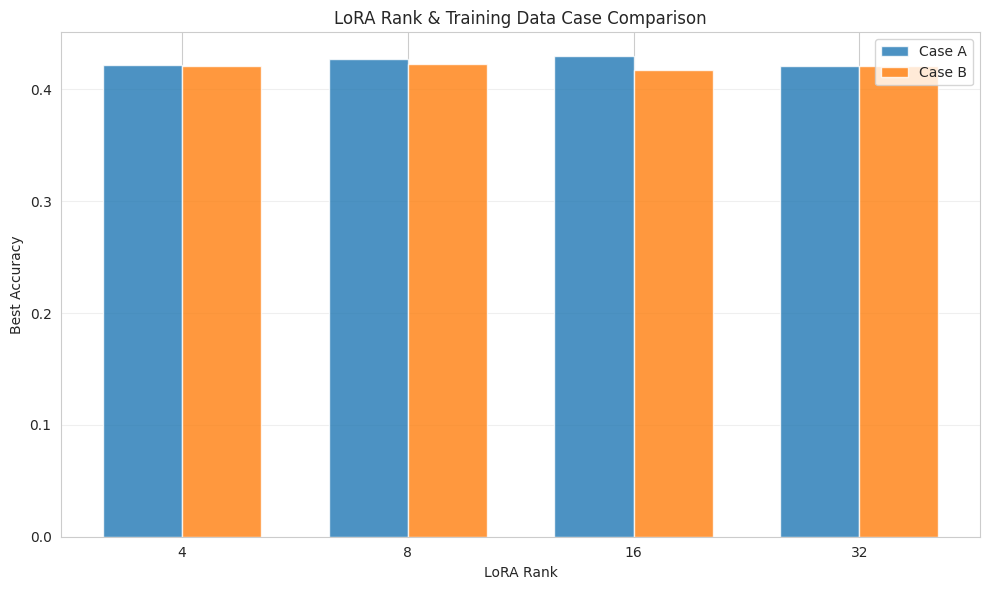

In [5]:
# LoRA 모델만 추출
lora_results = {}
for k, v in gen_models.items():
    if 'vanilla' not in k:
        parts = k.replace('gen_rank', '').split('_case')
        rank = int(parts[0])
        case = parts[1]
        if rank not in lora_results:
            lora_results[rank] = {}
        lora_results[rank][case] = v['best_acc']

# 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ranks = sorted(lora_results.keys())
case_a = [lora_results[r]['A'] for r in ranks]
case_b = [lora_results[r]['B'] for r in ranks]

x = range(len(ranks))
width = 0.35

ax.bar([i - width/2 for i in x], case_a, width, label='Case A', alpha=0.8)
ax.bar([i + width/2 for i in x], case_b, width, label='Case B', alpha=0.8)

ax.set_xlabel('LoRA Rank')
ax.set_ylabel('Best Accuracy')
ax.set_title('LoRA Rank & Training Data Case Comparison')
ax.set_xticks(x)
ax.set_xticklabels(ranks)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./results/exp1_lora_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

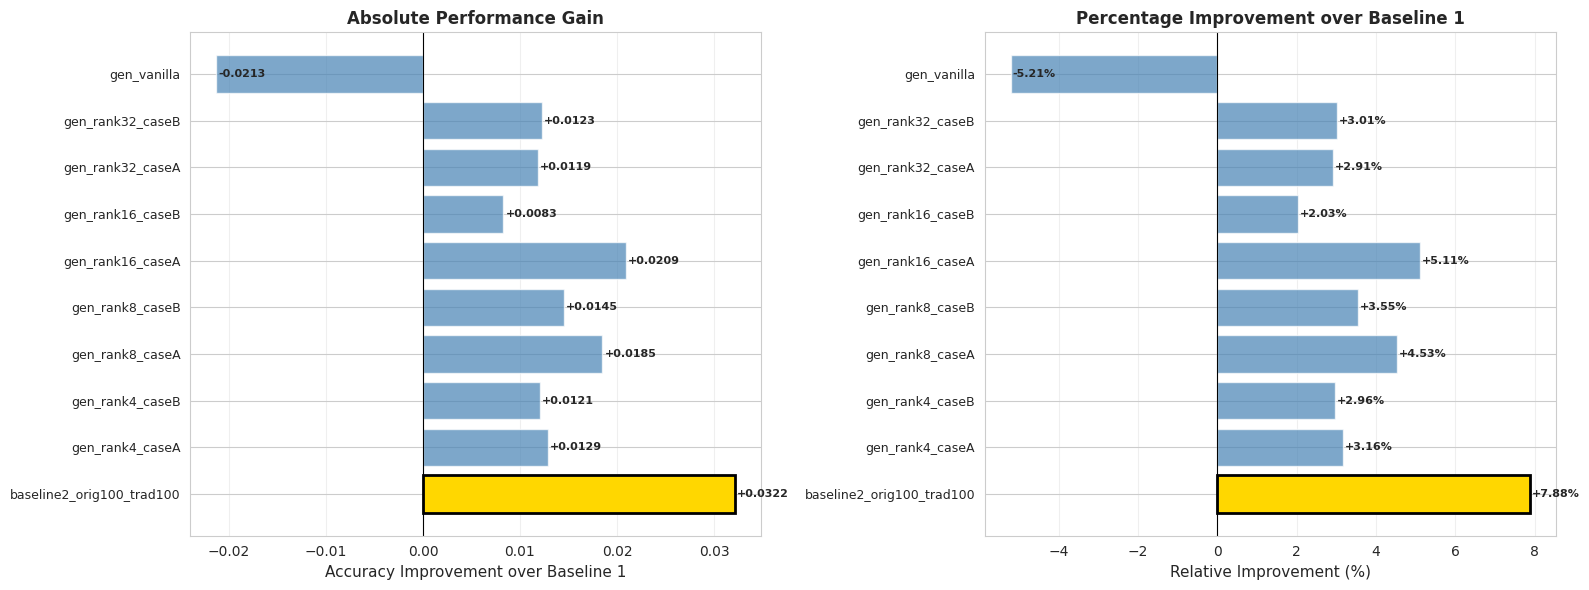


Baseline 1 Accuracy: 0.4087

Method                                   Acc      Delta      Improve % 
----------------------------------------------------------------------
baseline2_orig100_trad100                0.4409   +0.0322     +7.88% <-- BEST
gen_rank16_caseA                         0.4296   +0.0209     +5.11%
gen_rank8_caseA                          0.4272   +0.0185     +4.53%
gen_rank8_caseB                          0.4232   +0.0145     +3.55%
gen_rank4_caseA                          0.4216   +0.0129     +3.16%
gen_rank32_caseB                         0.4210   +0.0123     +3.01%
gen_rank4_caseB                          0.4208   +0.0121     +2.96%
gen_rank32_caseA                         0.4206   +0.0119     +2.91%
gen_rank16_caseB                         0.4170   +0.0083     +2.03%
gen_vanilla                              0.3874   -0.0213     -5.21%


In [6]:
# Baseline 1 대비 성능 향상도 계산
baseline1_acc = results_exp1['baseline1_orig100']['best_acc']

improvements = {}
for name, res in results_exp1.items():
    if name != 'baseline1_orig100':
        delta = res['best_acc'] - baseline1_acc
        improvement_pct = (delta / baseline1_acc) * 100
        improvements[name] = {
            'accuracy': res['best_acc'],
            'delta': delta,
            'improvement_pct': improvement_pct
        }

# 그래프
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 왼쪽: 절대 성능 향상 (좁은 범위)
names = list(improvements.keys())
deltas = [improvements[k]['delta'] for k in names]
colors = ['crimson' if 'baseline2' in k else 'steelblue' if 'gen_' in k else 'gray' for k in names]

bars1 = ax1.barh(range(len(names)), deltas, color=colors, alpha=0.7)

# 최고 성능 강조
best_idx = deltas.index(max(deltas))
bars1[best_idx].set_color('gold')
bars1[best_idx].set_alpha(1.0)
bars1[best_idx].set_edgecolor('black')
bars1[best_idx].set_linewidth(2)

ax1.set_yticks(range(len(names)))
ax1.set_yticklabels(names, fontsize=9)
ax1.set_xlabel('Accuracy Improvement over Baseline 1', fontsize=11)
ax1.set_title('Absolute Performance Gain', fontsize=12, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax1.grid(axis='x', alpha=0.3)

# 값 표시
for i, (name, delta) in enumerate(zip(names, deltas)):
    ax1.text(delta + 0.0002, i, f'{delta:+.4f}', 
             va='center', fontsize=8, fontweight='bold')

# 오른쪽: 상대 성능 향상 (%)
improvement_pcts = [improvements[k]['improvement_pct'] for k in names]

bars2 = ax2.barh(range(len(names)), improvement_pcts, color=colors, alpha=0.7)
bars2[best_idx].set_color('gold')
bars2[best_idx].set_alpha(1.0)
bars2[best_idx].set_edgecolor('black')
bars2[best_idx].set_linewidth(2)

ax2.set_yticks(range(len(names)))
ax2.set_yticklabels(names, fontsize=9)
ax2.set_xlabel('Relative Improvement (%)', fontsize=11)
ax2.set_title('Percentage Improvement over Baseline 1', fontsize=12, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(axis='x', alpha=0.3)

# 값 표시
for i, (name, pct) in enumerate(zip(names, improvement_pcts)):
    ax2.text(pct + 0.05, i, f'{pct:+.2f}%', 
             va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('./results/exp1_improvements.png', dpi=300, bbox_inches='tight')
plt.show()

# 수치 요약
print("\n" + "="*70)
print(f"Baseline 1 Accuracy: {baseline1_acc:.4f}")
print("="*70)
print(f"\n{'Method':<40s} {'Acc':<8s} {'Delta':<10s} {'Improve %':<10s}")
print("-"*70)

sorted_improvements = sorted(improvements.items(), 
                            key=lambda x: x[1]['delta'], 
                            reverse=True)

for name, imp in sorted_improvements:
    mark = " <-- BEST" if imp['delta'] == max(deltas) else ""
    print(f"{name:<40s} {imp['accuracy']:.4f}   {imp['delta']:+.4f}     {imp['improvement_pct']:+.2f}%{mark}")

print("="*70)

## 실험 2: 하이브리드 증강 분석

1. Phase 1: 전통적 증강 포화점 탐색
2. Phase 2: 포화점 + 생성형 증강 추가 효과

In [8]:
from experiment_hybridAug import run_experiment_2

print("Starting Experiment 2...")
summary_exp2 = run_experiment_2(best_model_name=best_model.replace('gen_', ''))
print("\nExperiment 2 completed.")

Starting Experiment 2...

######################################################################
# EXPERIMENT 2: Hybrid Augmentation Analysis
######################################################################
Train: 1000 images (100 per class)
Test: 10000 images

Generating Traditional Augmentations (k=1~20)
k= 1: Already exists
k= 2: Already exists
k= 3: Already exists
k= 4: Already exists
k= 5: Already exists
k= 6: Already exists
k= 7: Already exists
k= 8: Already exists
k= 9: Already exists
k=10: Already exists
k=11: Already exists
k=12: Already exists
k=13: Already exists
k=14: Already exists
k=15: Already exists
k=16: Already exists
k=17: Already exists
k=18: Already exists
k=19: Already exists
k=20: Already exists

Phase 1: Traditional Augmentation Saturation Search

[k= 1] Original 100 + Traditional 100 (total 200/class)
Dataset size: 2000
[010] train 0.6499/0.7655  test 3.0101/0.3193  best 0.3779
[020] train 0.0140/0.9980  test 2.9586/0.4204  best 0.4248
[030] train 0.0006/

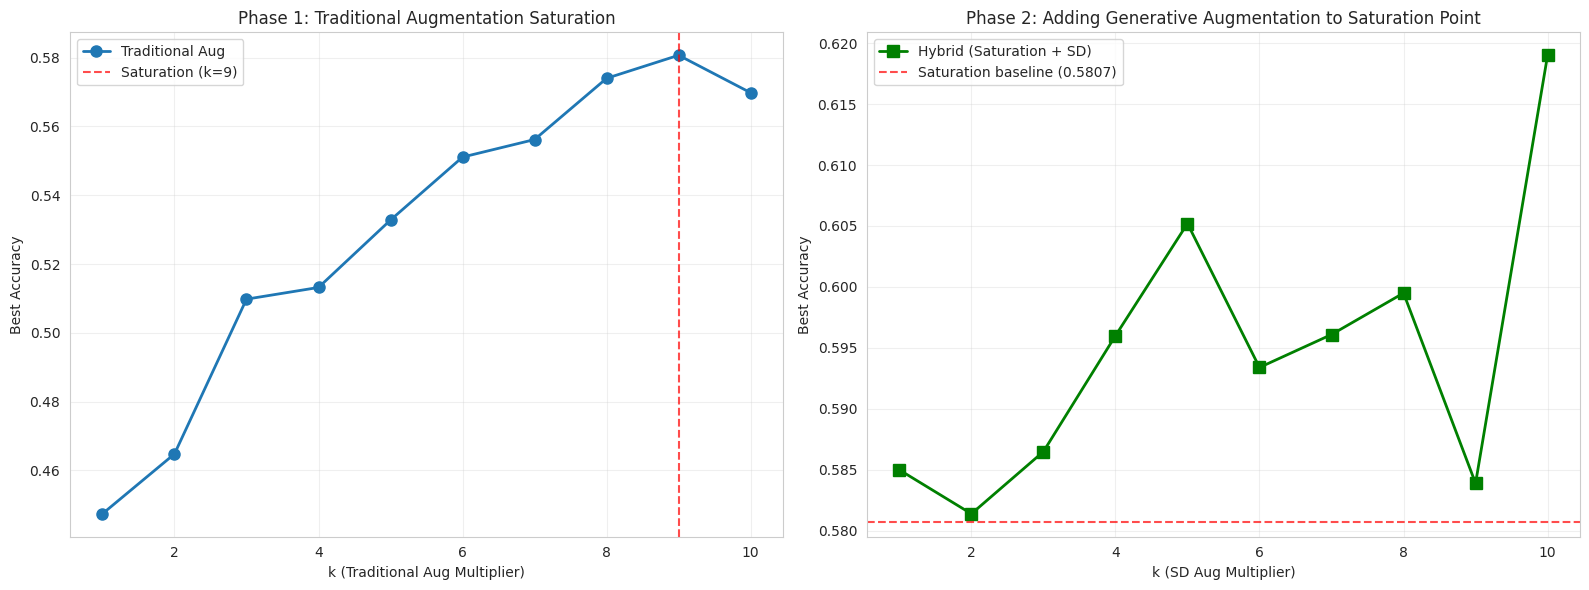

In [9]:
# 결과 로드
with open('./results/exp2_results.json', 'r') as f:
    summary_exp2 = json.load(f)

phase1 = summary_exp2['phase1_traditional']
phase2 = summary_exp2['phase2_hybrid']
saturation_k = summary_exp2['saturation_k']

# Phase 1: 전통적 증강 포화점
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 왼쪽: Phase 1
k_values = [r['k'] for r in phase1]
accs = [r['best_acc'] for r in phase1]

ax1.plot(k_values, accs, marker='o', linewidth=2, markersize=8, label='Traditional Aug')
ax1.axvline(x=saturation_k, color='red', linestyle='--', alpha=0.7, label=f'Saturation (k={saturation_k})')
ax1.set_xlabel('k (Traditional Aug Multiplier)')
ax1.set_ylabel('Best Accuracy')
ax1.set_title('Phase 1: Traditional Augmentation Saturation')
ax1.legend()
ax1.grid(alpha=0.3)

# 오른쪽: Phase 2
k_values_2 = [r['k'] for r in phase2]
accs_2 = [r['best_acc'] for r in phase2]
saturation_acc = summary_exp2['saturation_acc']

ax2.plot(k_values_2, accs_2, marker='s', linewidth=2, markersize=8, 
         color='green', label='Hybrid (Saturation + SD)')
ax2.axhline(y=saturation_acc, color='red', linestyle='--', alpha=0.7, 
            label=f'Saturation baseline ({saturation_acc:.4f})')
ax2.set_xlabel('k (SD Aug Multiplier)')
ax2.set_ylabel('Best Accuracy')
ax2.set_title('Phase 2: Adding Generative Augmentation to Saturation Point')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./results/exp2_phases.png', dpi=300, bbox_inches='tight')
plt.show()

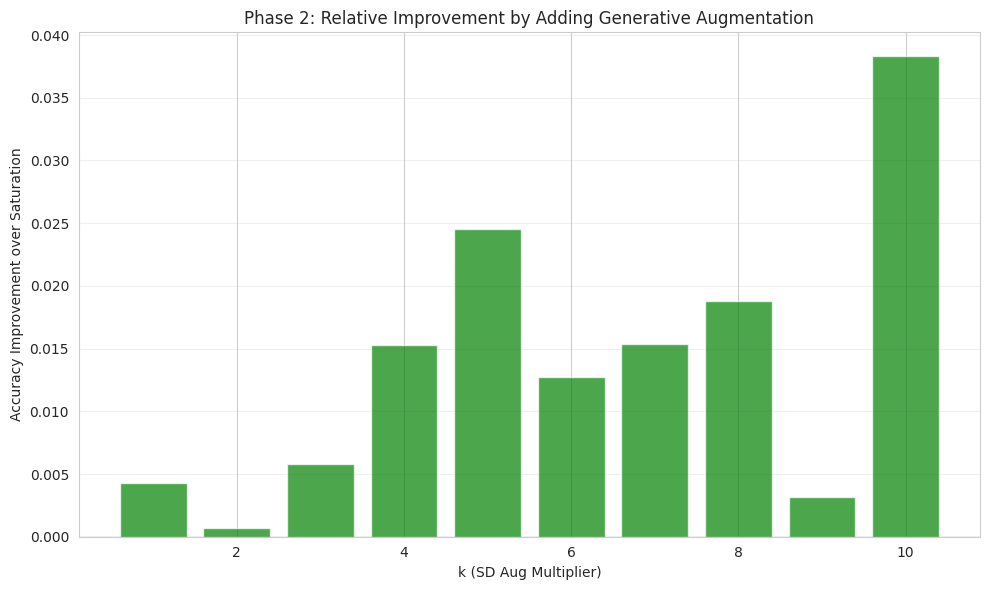


Final improvement: +0.0383


In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

k_values_2 = [r['k'] for r in phase2]
deltas = [r['best_acc'] - saturation_acc for r in phase2]

colors = ['green' if d > 0 else 'red' for d in deltas]
bars = ax.bar(k_values_2, deltas, color=colors, alpha=0.7)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('k (SD Aug Multiplier)')
ax.set_ylabel('Accuracy Improvement over Saturation')
ax.set_title('Phase 2: Relative Improvement by Adding Generative Augmentation')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./results/exp2_improvements.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFinal improvement: {deltas[-1]:+.4f}")

In [11]:
print("="*70)
print("FINAL SUMMARY")
print("="*70)

print("\n[Experiment 1: Optimal Generative Model]")
print(f"  Best Model: {best_model}")
print(f"  Best Accuracy: {results_exp1[f'{best_model}']['best_acc']:.4f}")
print(f"  vs Baseline 1 (원본만): {results_exp1['baseline1_orig100']['best_acc']:.4f}")
print(f"  vs Baseline 2 (원본+전통): {results_exp1['baseline2_orig100_trad100']['best_acc']:.4f}")

print("\n[Experiment 2: Hybrid Augmentation]")
print(f"  Saturation Point: k={saturation_k}, acc={saturation_acc:.4f}")
print(f"  Final Hybrid Accuracy: {phase2[-1]['best_acc']:.4f}")
print(f"  Improvement: {phase2[-1]['best_acc'] - saturation_acc:+.4f}")

print("\n" + "="*70)

# 결과 저장
final_summary = {
    'experiment1': {
        'best_model': best_model,
        'best_accuracy': results_exp1[f'{best_model}']['best_acc'],
        'baseline1': results_exp1['baseline1_orig100']['best_acc'],
        'baseline2': results_exp1['baseline2_orig100_trad100']['best_acc']
    },
    'experiment2': {
        'saturation_k': saturation_k,
        'saturation_acc': saturation_acc,
        'final_hybrid_acc': phase2[-1]['best_acc'],
        'improvement': phase2[-1]['best_acc'] - saturation_acc
    }
}

with open('./results/final_summary.json', 'w') as f:
    json.dump(final_summary, f, indent=2)

print("Results saved to ./results/")

FINAL SUMMARY

[Experiment 1: Optimal Generative Model]
  Best Model: gen_rank16_caseA
  Best Accuracy: 0.4296
  vs Baseline 1 (원본만): 0.4087
  vs Baseline 2 (원본+전통): 0.4409

[Experiment 2: Hybrid Augmentation]
  Saturation Point: k=9, acc=0.5807
  Final Hybrid Accuracy: 0.6190
  Improvement: +0.0383

Results saved to ./results/


In [12]:
# Experiment 1 테이블
exp1_data = []
for name, res in results_exp1.items():
    exp1_data.append({
        'Method': name,
        'Train Size': res['train_size'],
        'Best Acc': f"{res['best_acc']:.4f}",
        'Final Acc': f"{res['final_acc']:.4f}"
    })

df1 = pd.DataFrame(exp1_data)
print("\n=== Experiment 1 Results ===")
print(df1.to_string(index=False))

# Experiment 2 테이블
exp2_data = []
for res in phase1:
    exp2_data.append({
        'Phase': 'Traditional',
        'k': res['k'],
        'Train Size': res['train_size'],
        'Best Acc': f"{res['best_acc']:.4f}"
    })

for res in phase2:
    exp2_data.append({
        'Phase': 'Hybrid',
        'k': res['k'],
        'Train Size': res['train_size'],
        'Best Acc': f"{res['best_acc']:.4f}"
    })

df2 = pd.DataFrame(exp2_data)
print("\n=== Experiment 2 Results ===")
print(df2.to_string(index=False))

# CSV 저장
df1.to_csv('./results/exp1_table.csv', index=False)
df2.to_csv('./results/exp2_table.csv', index=False)
print("\nTables saved to CSV files.")


=== Experiment 1 Results ===
                   Method  Train Size Best Acc Final Acc
        baseline1_orig100        1000   0.4087    0.4073
baseline2_orig100_trad100        2000   0.4409    0.4390
          gen_rank4_caseA        2000   0.4216    0.4195
          gen_rank4_caseB        2000   0.4208    0.4200
          gen_rank8_caseA        2000   0.4272    0.4239
          gen_rank8_caseB        2000   0.4232    0.4205
         gen_rank16_caseA        2000   0.4296    0.4268
         gen_rank16_caseB        2000   0.4170    0.4147
         gen_rank32_caseA        2000   0.4206    0.4199
         gen_rank32_caseB        2000   0.4210    0.4207
              gen_vanilla        2000   0.3874    0.3858

=== Experiment 2 Results ===
      Phase  k  Train Size Best Acc
Traditional  1        2000   0.4474
Traditional  2        3000   0.4648
Traditional  3        4000   0.5098
Traditional  4        5000   0.5132
Traditional  5        6000   0.5328
Traditional  6        7000   0.5511
Trad